In [1]:
!pip install faker
!pip install tqdm

     |████████████████████████████████| 1.0MB 2.7MB/s 


In [2]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt

import random
from tqdm import tqdm

from faker import Faker
import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

# Laden der Daten

In [3]:
def Download(fname):
  url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname

  r = requests.get(url)
  open(fname , 'wb').write(r.content)
  print("Geladen")
  # Extracting the dataset
  tar = tarfile.open(fname)
  tar.extractall()
  tar.close()

In [4]:
fname = 'examples.tar.gz'
Download(fname)

Geladen


In [5]:
fname = 'labels.tar.gz'
Download(fname)

Geladen


In [6]:
fname = 'val.tar.gz'
Download(fname)

Geladen


In [7]:
#fname = 'train-0.tar.gz'
#Download(fname)

In [8]:
#fname = 'train-1.tar.gz'
#Download(fname)

In [34]:
# Parse the JSON file and read all the images and labels
with open('publaynet/val.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "publaynet/val/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)



In [35]:
# Function to viz the annotation
def markup(image, annotations):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw bbox
        # "bbox": [37.59, 433.64, 251.07, 20.38]
      tempImage = image.crop((annotation['bbox'][0],
            annotation['bbox'][1],
            annotation['bbox'][0] + annotation['bbox'][2],
            annotation['bbox'][1] + annotation['bbox'][3]))
      tempImage = tempImage.resize((120,120))
      Kategorie = outline=samples['categories'][annotation['category_id'] - 1]['id']
    return np.array(tempImage), np.array(Kategorie)

In [36]:
def createZielDaten(Number):
  Ziel = []
  for i in range(0,6):
    Ziel.append(0)
  Ziel[Number] = 1
  return Ziel

# Vorbereitung fürs Netz

In [37]:
# text ("1"), title ("2"), list ("3"), table ("4"), figure ("5").
# "bbox": [37.59, 360.34, 251.07, 41.36]

x = []
y = []

# Ausschneiden und ausgeben
for i, (_, image) in enumerate(images.items()):
  try:
    with Image.open(image['file_name']) as img:
      TempImage, Kategorie = markup(img, image['annotations'])
      x.append(TempImage)
      y.append(Kategorie)
  except Exception:
    continue

temp_Zieldaten = y
y = []

for i in temp_Zieldaten:
  y.append(createZielDaten(i))

x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(11245, 120, 120, 3)
(11245, 6)


# Bau des Models

In [38]:
x = np.array(x)
y = np.array(y)

Wir haben 5 verschiedene Kategorien:

1.   title
2.   text
3.   figure
4.   tabel
5.   list


In [39]:
input = keras.layers.Input((120,120,3))

CNN = keras.layers.Conv2D(60, (2,2) , activation='relu')(input)
CNN = keras.layers.MaxPooling2D((2,2))(input)
CNN = keras.layers.Conv2D(64, (3,3), activation='relu')(CNN)
CNN = keras.layers.MaxPooling2D((2,2))(CNN)
CNN = keras.layers.Conv2D(32, (3,3), activation='relu')(CNN)

Wertung = keras.layers.Flatten()(CNN)
Wertung = keras.layers.Dense(64, activation='relu')(Wertung)

Output = keras.layers.Dense((6), activation = 'sigmoid')(Wertung)


model = keras.models.Model(input, Output)

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# Training


In [40]:
csv_logger = CSVLogger('log.csv', append=True, separator=';')

history = model.fit(x, y, epochs=16, validation_split=0.3, callbacks=[csv_logger])

model.save('model')

Epoch 1/32
246/246 [==============================] - 53s 216ms/step - loss: 1.4331 - accuracy: 0.7827 - val_loss: 0.4312 - val_accuracy: 0.4194
Epoch 2/32
246/246 [==============================] - 54s 218ms/step - loss: 0.2278 - accuracy: 0.7697 - val_loss: 0.4596 - val_accuracy: 0.3121
Epoch 3/32
246/246 [==============================] - 54s 218ms/step - loss: 0.2663 - accuracy: 0.7008 - val_loss: 0.4371 - val_accuracy: 0.3524
Epoch 4/32
246/246 [==============================] - 53s 217ms/step - loss: 0.1810 - accuracy: 0.7254 - val_loss: 0.5205 - val_accuracy: 0.3574
Epoch 5/32
246/246 [==============================] - 54s 219ms/step - loss: 0.1442 - accuracy: 0.8110 - val_loss: 0.5152 - val_accuracy: 0.4143
Epoch 6/32
246/246 [==============================] - 54s 219ms/step - loss: 0.1173 - accuracy: 0.8576 - val_loss: 0.6945 - val_accuracy: 0.4303
Epoch 7/32
246/246 [==============================] - 54s 218ms/step - loss: 0.1102 - accuracy: 0.8685 - val_loss: 0.9397 - val_ac

In [41]:
from google.colab import files

files.download('log.csv')

MessageError: ignored

# Auswertung


In [42]:
plt.xkcd()

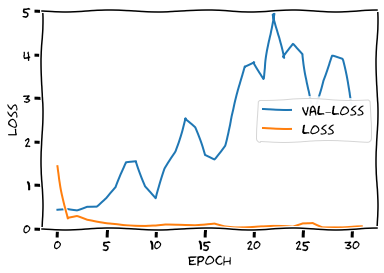

In [46]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='center right')
plt.show()

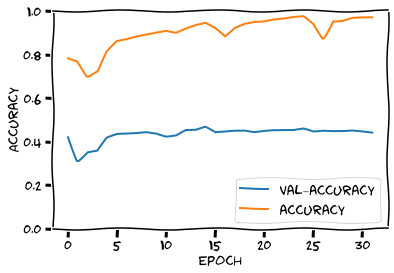

In [44]:
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Analyse

In [47]:
#fname = 'val.tar.gz'
#Download(fname)

In [48]:
# Parse the JSON file and read all the images and labels
with open('examples/samples.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

x = []
y = []

# Ausschneiden und ausgeben
for i, (_, image) in enumerate(images.items()):
    with Image.open(image['file_name']) as img:
      TempImage, Kategorie = markup(img, image['annotations'])
      # x.append(TempImage[:, :, 0])
      x.append(TempImage)
      y.append(Kategorie)


x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(20, 120, 120, 3)
(20,)


In [49]:
Ergebnis = []
prediction = model.predict(x)

for i in range(len(prediction)):
  maxWert = 0
  Stelle = 0
  for b in range(len(prediction[0])):
    if(prediction[i][b] > maxWert):
      Stelle = b
      maxWert = prediction[i][b]

  Ergebnis.append(Stelle)

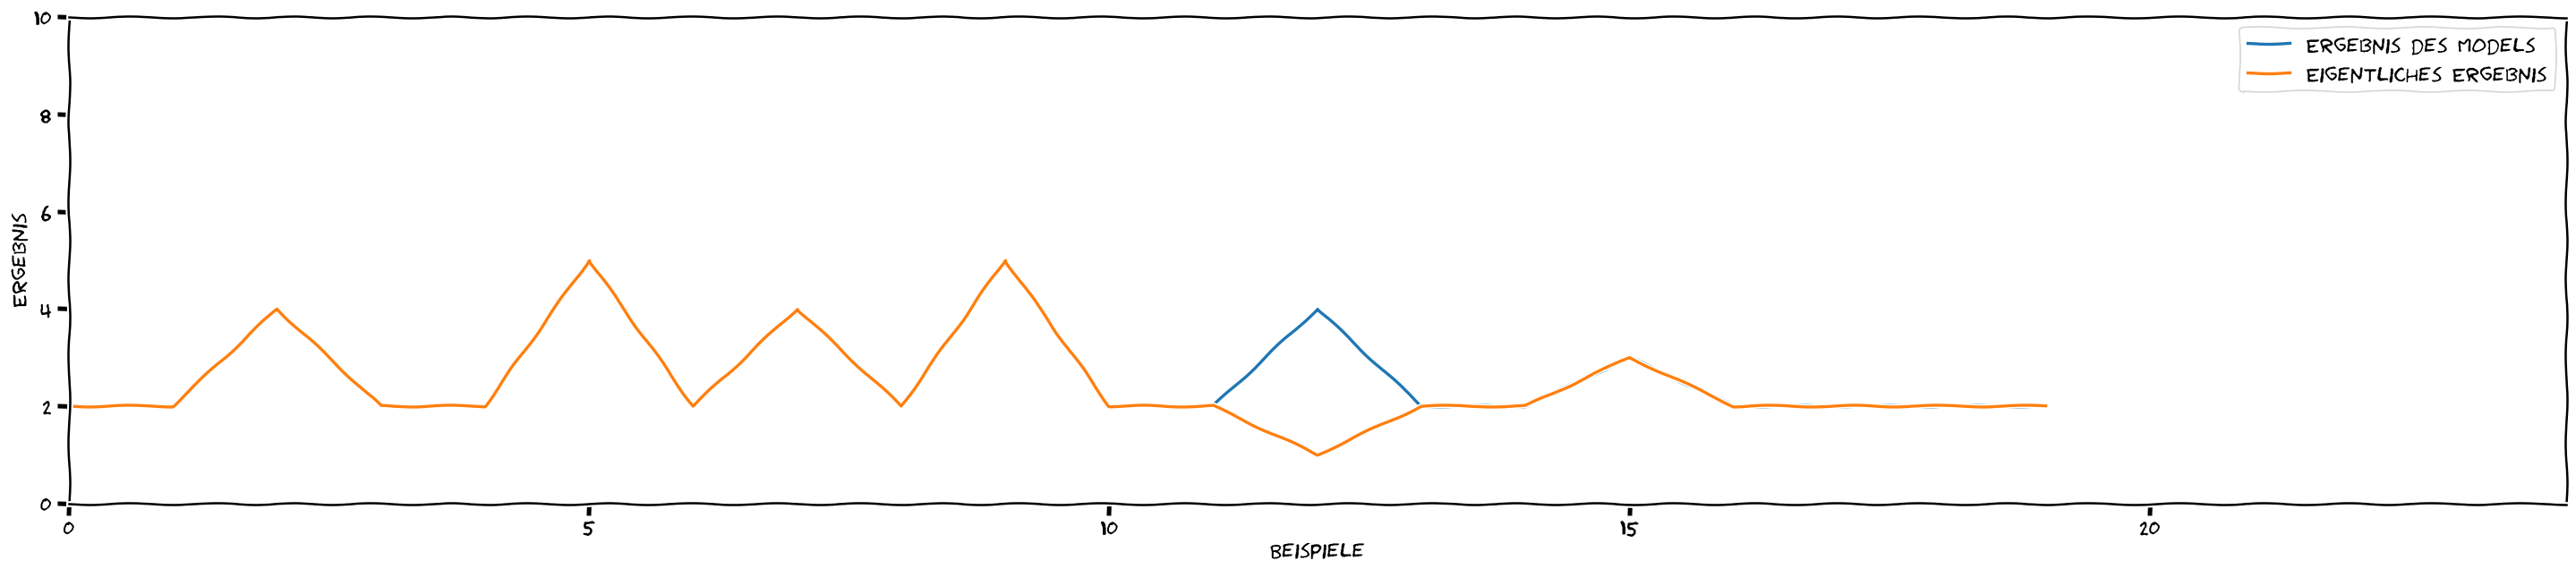

In [50]:
plt.figure(num=None, figsize=(30, 6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(Ergebnis, label = 'Ergebnis des Models')
plt.plot(y, label ='Eigentliches Ergebnis')

plt.xlabel('Beispiele')
plt.ylabel('Ergebnis')
plt.ylim([0, 10])
plt.xlim([0, len(x)+4])
plt.legend(loc='upper right')
plt.show()

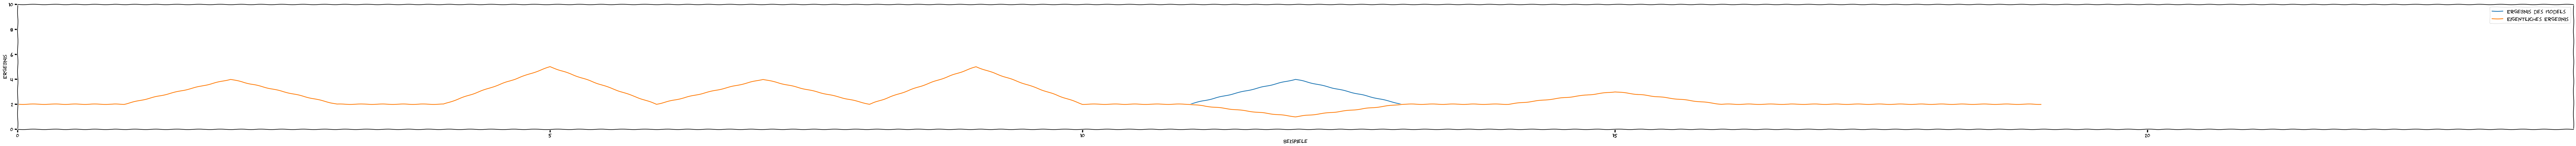

In [51]:
plt.figure(num=None, figsize=(120, 6), dpi=120, facecolor='w', edgecolor='k')

plt.plot(Ergebnis, label = 'Ergebnis des Models')
plt.plot(y, label ='Eigentliches Ergebnis')

plt.xlabel('Beispiele')
plt.ylabel('Ergebnis')
plt.ylim([0, 10])
plt.xlim([0, len(x)+4])
plt.legend(loc='upper right')
plt.show()